In [32]:
import pandas as pd
import numpy as np
import math
from sklearn.cluster import KMeans
import sklearn.preprocessing as preprocessing
from sklearn.cluster import DBSCAN
from sklearn import linear_model
import scipy.interpolate as ip
from sklearn.mixture import GaussianMixture
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('Indicators.csv')
data.shape

(5656458, 6)

In [3]:
data.head()

,CountryName,CountryCode,IndicatorName,IndicatorCode,Year,Value
0,Arab World,ARB,"Adolescent fertility rate (births per 1,000 wo...",SP.ADO.TFRT,1960,1.335609e+02
1,Arab World,ARB,Age dependency ratio (% of working-age populat...,SP.POP.DPND,1960,8.779760e+01
2,Arab World,ARB,"Age dependency ratio, old (% of working-age po...",SP.POP.DPND.OL,1960,6.634579e+00
3,Arab World,ARB,"Age dependency ratio, young (% of working-age ...",SP.POP.DPND.YG,1960,8.102333e+01
4,Arab World,ARB,Arms exports (SIPRI trend indicator values),MS.MIL.XPRT.KD,1960,3.000000e+06


In [4]:
def corr(data, column):
    data=data[(data['Year'] >= 2000) & (data['Year'] < 2014) ]
    for i in data.columns:
        if data.isna().sum()[i]/len(data) >=0.8:
            data=data.drop(columns=[i])

    rel_columns= []
    rel_columns_7=[]
    unique_name = data['IndicatorName'].unique()
    for i in range(len(unique_name)):
        #print(unique_name[i])
        indicator = data[data['IndicatorName'] == unique_name[i]]
        indicator.rename(columns={"Value": unique_name[i]}, inplace = True)
        indicator=indicator.drop(columns=['IndicatorCode', 'IndicatorName', 'CountryName'])
        merged = pd.merge(target, indicator)
        corr=merged.corr()
        if corr["Value"][unique_name[i]] > 0.8 or corr["Value"][unique_name[i]] < -0.8:
            rel_columns.append(unique_name[i])
        if corr['Value'][unique_name[i]] > 0.7 or corr["Value"][unique_name[i]] < -0.7:
            rel_columns_7.append(unique_name[i])
    return rel_columns, rel_columns_7

In [5]:
#일단 이렇게 되는데, 나중에 주석 풀고 하는게 나을듯
#rel_columns_8,rel_columns_7=corr(data2000)

In [6]:
# 여기서부터 관련도 높은 feature 뽑는 것
target_id = 'Adolescent fertility rate (births per 1,000 women ages 15-19)';

target = data[data['IndicatorName']==target_id]

In [7]:
rel_columns_8 = ['Adolescent fertility rate (births per 1,000 women ages 15-19)',
 'Birth rate, crude (per 1,000 people)',
 'Net enrolment rate, secondary, both sexes (%)',
 'Net enrolment rate, secondary, female (%)',
 'Net enrolment rate, secondary, male (%)',
 'Teenage mothers (% of women ages 15-19 who have had children or are currently pregnant)',
 'Mortality rate, under-5, female (per 1,000 live births)',
 'Mortality rate, under-5, male (per 1,000 live births)',
 'Prevalence of anemia among children (% of children under 5)',
 'Cause of death, by communicable diseases and maternal, prenatal and nutrition conditions (% of total)',
 'Cause of death, by non-communicable diseases (% of total)',
 'Survey mean consumption or income per capita, bottom 40% of population (2005 PPP $ per day)',
 'Survey mean consumption or income per capita, total population (2005 PPP $ per day)']

In [8]:
rel_columns_7 = ['Adolescent fertility rate (births per 1,000 women ages 15-19)',
 'Age dependency ratio (% of working-age population)',
 'Age dependency ratio, young (% of working-age population)',
 'Birth rate, crude (per 1,000 people)',
 'Fertility rate, total (births per woman)',
 'Life expectancy at birth, female (years)',
 'Life expectancy at birth, male (years)',
 'Life expectancy at birth, total (years)',
 'Mortality rate, adult, female (per 1,000 female adults)',
 'Mortality rate, infant (per 1,000 live births)',
 'Mortality rate, under-5 (per 1,000)',
 'Population, ages 0-14 (% of total)',
 'Population, ages 15-64 (% of total)',
 'Survival to age 65, female (% of cohort)',
 'Survival to age 65, male (% of cohort)',
 'Adjusted net enrolment rate, primary, both sexes (%)',
 'Adjusted net enrolment rate, primary, female (%)',
 'Gross enrolment ratio, secondary, both sexes (%)',
 'Gross enrolment ratio, secondary, female (%)',
 'Gross enrolment ratio, secondary, male (%)',
 'Lower secondary completion rate, both sexes (%)',
 'Net enrolment rate, secondary, both sexes (%)',
 'Net enrolment rate, secondary, female (%)',
 'Net enrolment rate, secondary, male (%)',
 'Primary completion rate, both sexes (%)',
 'Primary completion rate, female (%)',
 'Survival rate to the last grade of primary education, both sexes (%)',
 'Lower secondary completion rate, female (%)',
 'Lower secondary completion rate, male (%)',
 'Survival rate to the last grade of primary education, female (%)',
 'Survival rate to the last grade of primary education, male (%)',
 'Survival rate to Grade 5 of primary education, female (%)',
 'Youth literacy rate, population 15-24 years, both sexes (%)',
 'Youth literacy rate, population 15-24 years, male (%)',
 'Teenage mothers (% of women ages 15-19 who have had children or are currently pregnant)',
 'Wanted fertility rate (births per woman)',
 'Access to electricity (% of population)',
 'Access to electricity, rural (% of rural population)',
 'Improved sanitation facilities (% of population with access)',
 'Improved sanitation facilities, rural (% of rural population with access)',
 'Improved sanitation facilities, urban (% of urban population with access)',
 'Improved water source (% of population with access)',
 'Improved water source, rural (% of rural population with access)',
 'Lifetime risk of maternal death (%)',
 'Maternal mortality ratio (modeled estimate, per 100,000 live births)',
 'Mortality rate, infant, female (per 1,000 live births)',
 'Mortality rate, infant, male (per 1,000 live births)',
 'Mortality rate, neonatal (per 1,000 live births)',
 'Mortality rate, under-5, female (per 1,000 live births)',
 'Mortality rate, under-5, male (per 1,000 live births)',
 'Prevalence of anemia among children (% of children under 5)',
 'Prevalence of anemia among pregnant women (%)',
 'Renewable energy consumption (% of total final energy consumption)',
 'Cause of death, by communicable diseases and maternal, prenatal and nutrition conditions (% of total)',
 'Cause of death, by non-communicable diseases (% of total)',
 'Survey mean consumption or income per capita, bottom 40% of population (2005 PPP $ per day)',
 'Survey mean consumption or income per capita, total population (2005 PPP $ per day)']

In [9]:
# 해당하는 indicator해서 그 데이터 프레임 사용하기 편하게 바꿔주는거 
def transformDf(d, ind, tf):
    data2000=d[(d['Year'] >= 2006) & (d['Year'] < 2014) ]
    
    
    if tf==True:
        
        col8 = data2000[(data2000['IndicatorName'].isin(ind))]
        col8=col8.reset_index(drop=True)
        
    else:
        col8 = data2000[data2000['IndicatorName']==ind]
        col8=col8.reset_index(drop=True)
    
    name_list = list()

    for i in col8.index:
        name_list.append( col8.loc[i,'CountryName'] + "_" + str(col8.loc[i,'Year']))
    col8["name"] = name_list

    col8=col8.pivot_table(values="Value",index="name",columns=["IndicatorName"] )

    if tf==True:
        col8=col8.dropna(subset=[target_id])
    return col8
    
    

In [10]:
df=transformDf(data,rel_columns_8,True)

In [11]:

def make_grade(merged, k):
    min_value = min(merged[target_id])
    max_value = max(merged[target_id])
    value=(max_value-min_value)/k
    for i in range(k):
        for j in merged.index:
            if merged.loc[j, target_id] >=min_value + value*i and merged.loc[j, target_id] <= min_value + value*(i+1):
                merged.loc[j, 'grade'] = i
    return merged


In [12]:
def preprocessingMissing(df):
    
    #전체 개수랑 null 값이 비슷 하게 나오는 경우에는 그냥 아예 그 컬럼을 안쓰는게 나을 거 가음
    for i in df.columns:
        if df.isna().sum()[i]/len(df) >=0.7:
            df=df.drop(columns=[i])
            
    data_inter=pd.DataFrame(data=df.values,index=range(len(df)))
    data_inter=data_inter.interpolate(method='index' ,limit_direction="both")
    df=pd.DataFrame(data=data_inter.values,index=df.index, columns=df.columns)


    return df
        

In [13]:
df1=preprocessingMissing(df)


In [14]:
# cleansing dataset
def robust(X):
    # cleansing missing data
    X.dropna(axis=0, thresh=1, inplace=True)
    # cleansing outliers
    robust = preprocessing.RobustScaler().fit(X)

    X_robust = robust.transform(X)
    X_robust = pd.DataFrame(X, columns=X.columns, index=list(X.index.values))
    return X_robust

In [15]:
# scaling data (MinMaxScaler)
def minmax(X):
    scaler = preprocessing.MinMaxScaler()
    fit = scaler.fit(X)

    X_scaled = scaler.transform(X)
    X_scaled = pd.DataFrame(X_scaled, columns=X.columns, index=list(X.index.values))
    return X_scaled

In [16]:
# scaling data (MinMaxScaler)
def standard(X):
    scaler = preprocessing.StandardScaler()
    fit = scaler.fit(X)

    X_scaled = scaler.transform(X)
    X_scaled = pd.DataFrame(X_scaled, columns=X.columns, index=list(X.index.values))
    return X_scaled


In [17]:
def fillnaX(X):
    for i in X.columns:
        df[i] = df[i].fillna(df[i].mean())
    return X                     

In [53]:
#나중에 dbscan이나 EM 도 한파일에 있어야되서 함수 명 바꿧어
def runKMeans(df, k,max_iter, n_init):
    
    df=make_grade(df,k)
    kmeans= KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=max_iter, 
               n_clusters=k, n_init=n_init, n_jobs=1, precompute_distances='auto', 
               random_state=None, tol=0.0001, verbose=0)
    
    X= df.drop(['grade',target_id], 1)
    #일단은 다 dropna 처리
    X=X.dropna()
    y=df['grade']

    kmeans.fit(X)
    predict=kmeans.predict(X)
    scatter_plot(df, predict)
    return calcAccuracy(predict, X,y)

In [19]:

def calcAccuracy(y_pred, x,y):
    '''
    print accuracy of prediction
    '''
    correct=0
    for i in range(len(x)):
        
        #predict_me= np.array(x[i].astype(float))
        #predict_me = predict_me.reshape(-1, len(predict_me))
        #prediction = kmeans.predict(predict_me)
        #여기서는 predict 값을 넘겨서 [i]로 해야돼
        if y_pred[i] == y[i]:
            correct += 1
    print(correct/len(x))


In [95]:
def runDBSCAN(df,eps, min_samples, metric):
    
    df=make_grade(df,min_samples)
    X=df.drop(columns=['grade',target_id])
    y=df['grade']
    
    """
    X=df.drop(columns=[target_id])
    y=df[target_id]
    """
    
    """
    X = robust(X)
    X= fillnaX(X)
    """
    db = DBSCAN(eps = eps, min_samples = min_samples, metric= metric).fit(X) 

    cluster_labels = db.labels_
    n_clusters = len(set(cluster_labels))
    print(cluster_labels)
    scatter_plot(df, cluster_labels)
    
    return calcAccuracy(cluster_labels, X,y)

In [102]:
def runGMM(df, k):
    df=make_grade(df,k)

    X = df.drop(columns=[target_id])
    y=df['grade']
    
   
    #X= fillnaX(X)
    gmm = GaussianMixture(n_components=k)
    gmm.fit(X)

    y_cluster_gmm = gmm.predict(X)
    scatter_plot(df, y_cluster_gmm)

    return calcAccuracy(y_cluster_gmm, X, y)

In [27]:
df=transformDf(data,rel_columns_8,True)
df=preprocessingMissing(df)

[1 1 1 ... 1 1 1]
name
Afghanistan_2006    1.0
Afghanistan_2007    1.0
Afghanistan_2008    1.0
Afghanistan_2009    0.0
Afghanistan_2010    0.0
                   ... 
Zimbabwe_2009       1.0
Zimbabwe_2010       1.0
Zimbabwe_2011       1.0
Zimbabwe_2012       1.0
Zimbabwe_2013       1.0
Name: grade, Length: 1816, dtype: float64


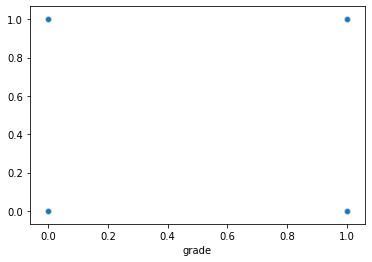

0.7384361233480177


In [55]:
runKMeans(df,2,600,20)

In [24]:
eps=[10, 20, 30, 40, 50 ]
min_samples=[ 3, 5, 10, 15, 20, 30, 50, 100 ]
dis_measure = ['euclidean', 'hamming']

[0 0 0 ... 0 0 0]


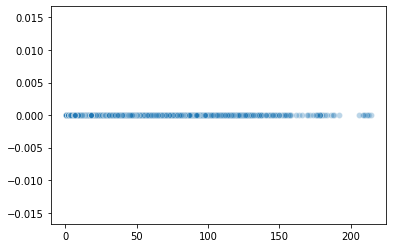

0.30837004405286345


In [101]:
runDBSCAN(df,50,10,'euclidean')

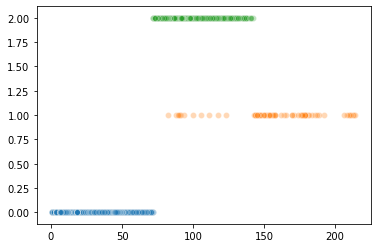

0.7290748898678414


In [105]:
runGMM(df, 3)

In [27]:
'''
선택지
1. rel_columns_8 or 7
2. 몇개 미만이면 제외할지
3. kmeans parameter
'''

'\n선택지\n1. rel_columns_8 or 7\n2. 몇개 미만이면 제외할지\n3. kmeans parameter\n'

In [184]:
def scatter_plot(df, predict):
    plt.figure(figsize=(15,5))
    for i in range(len(set(predict))):
        value = []
        for j in range(len(df)):
            if predict[j] == i:
                value.append(df.iloc[j][target_id])
        grade = [i]*len(value)
        sns.scatterplot(value, grade, alpha=0.3)
    plt.show()


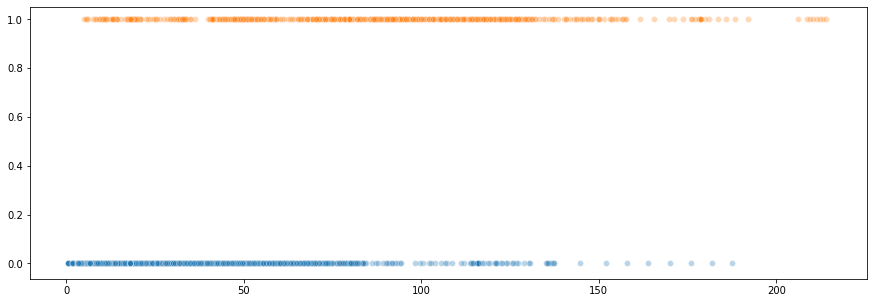

0.7384361233480177


In [185]:
runKMeans(df,2,600,30)

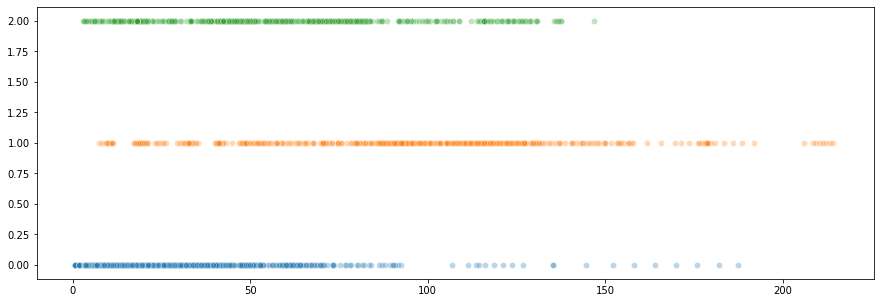

0.5748898678414097


In [186]:
runKMeans(df,3,600,30)

[0 0 0 ... 0 0 0]


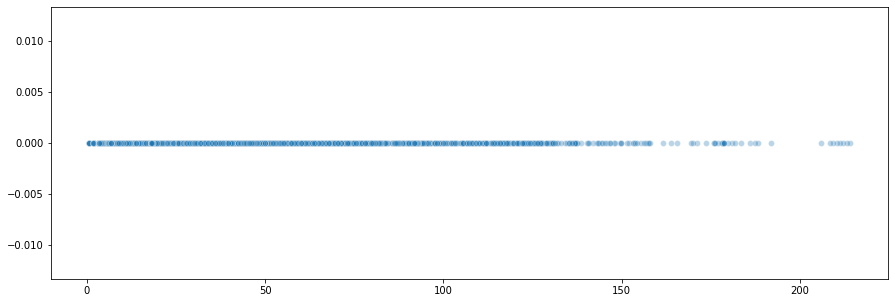

0.30837004405286345


In [187]:
runDBSCAN(df,50,10,'euclidean')

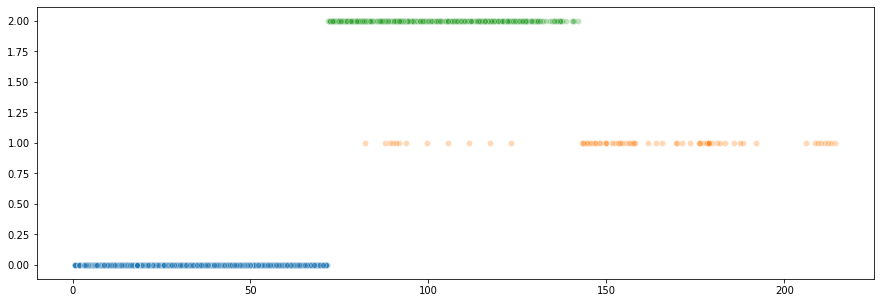

0.7290748898678414


In [188]:
runGMM(df, 3)